# How Much Do Men and Women in the U.S. Ask For in Hourly Bill Rate on Upwork? (24k dataset) 

In November 2017, we collected publicly available profiles for 24,373 workers worldwide on online freelancing platform, Upwork. We used Microsoft's Face API to detect gender of workers based on their profile photos, in contrast to prior literature that detected gender based on users' first names (e.g., Hannak et al., 2017, Wachs et al., 2017). Gender identification methods based on first name has been shown to have lower precision and recall in comparison to methods using facial recognition. We omitted profiles from the dataset if we could not reliably detect gender from their profile photo or if we could not identify the level of education for at least one of the entries on their profile. We also removed profiles that were outliers with bill rates more or less than two standard deviations from the average bill rate. To limit the scope of the analysis, we focused on workers based in the United States. In total, we included 4368 workers in our analyses (female = 1954). 

Following similar work in HCI measuring the effects of online behaviors (Choudhury et al., 2016), we used stratified propensity score matching to estimate the causal effects of gender on average hourly bill rate. In this model, we controlled for workers': 1) highest level of education, 2) primary job category specified on Upwork, and 3) number of years of work experience listed on their profile. 

Based on our causal model, we show that being a woman predicted signficantly lower bill rates (M = \$32.67, std = \$19.95) compared to being a man (M = \$38.12, std = \$22.54, p < 0.01). On average, women in our dataset asked for hourly bill rates that were 85.7% of what men in the dataset asked for. This figure is comparable to the gender pay gap for full-time, year-round workers in the United States in 2015; on average, women earned 80% of men's annual average wages (Institute for Women's Policy Research, 2016; see https://iwpr.org/issue/employment-education-economic-change/pay-equity-discrimination/). 

Below we describe the dataset and the analyses we conducted. 

In [12]:
import httplib2
import oauth2
import urllib3
import types
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from gender_detector import GenderDetector 
import psycopg2, psycopg2.extras
from causalinference import CausalModel
from causalinference.utils import random_data
import httplib
import base64
import json # For Microsoft Face API
import urllib as urllib # For Microsoft Face API
import time 
import csv
import datetime 
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Initialize arrays for Causal Analysis 
user_count = 1
bill_rate_array = []
gender_array = []
all_covariates_array = []

# Read data from csv files and reformat
all_data_file_name = '2017_11_01_upwork_unitedstates_allskills_nowork.csv' # Filename for all data
gender_data_file_name = '2017_11_01_upwork_gender_unitedstates_allskills.csv' # Filename for gender data
df = pd.read_csv(all_data_file_name)
df_gender = pd.read_csv(gender_data_file_name)

# Merge the files, then remove rows with an error, no gender identified, or ambiguous education
merged = df.merge(df_gender, on='user_count')
merged = merged[merged.bill_rate != 'error']
merged = merged[merged.gender != 'unidentified']
merged = merged[merged.gender != 'error']
merged = merged[merged.education != 'None']
merged = merged[merged.job_category != 'none']
merged = merged[merged.country == 'United States'] # Look only at data in the United States, which is the largest dataset

# Calculate mean and standard deviation
merged['bill_rate'] = merged.bill_rate.astype('float')
sd = np.std(merged['bill_rate'])
mean = np.mean(merged['bill_rate'])
print("Bill rate average: {0}".format(mean))
print("Bill rate standard deviation: {0}".format(sd))

# Remove outliers in the dataset
merged = merged[merged['bill_rate'] > mean - 2 * sd]
merged = merged[merged['bill_rate'] < mean + 2 * sd]

all_bill_rates = merged.bill_rate.astype('float')
merged['bill_rate'] = merged.bill_rate.astype('float')
# merged['work_experience'] = merged.work_experience.astype('float')
# all_work_experience = merged.work_experience
all_education_id = merged.education_id
all_job_category_id = merged.job_category_id
all_country_id = merged.country_id
all_genders = merged.gender
female_count = 0
male_count = 0

# Converting covariates to a matrix on a dichotomous scale
def make_dichotomous_matrix(id_value, covariate, final_matrix):
    for option in list(set(covariate)):
        if (id_value == option):
            final_matrix.append(1)
        else:
            final_matrix.append(0)
    return final_matrix

covariate_matrix = []
print make_dichotomous_matrix(20, all_country_id, covariate_matrix)
        
# Data formatting 
for gender in all_genders:
    if (gender == "male"):
        gender_array.append(0)
        male_count += 1
    elif (gender == "female"): # Female as the treatment group
        gender_array.append(1)
        female_count += 1

for rate in all_bill_rates:
    rate = round(float(rate), 2)
    bill_rate_array.append(rate)
    

for row in merged.itertuples():    
    job_category_matrix = []
    country_matrix = []
    education_matrix = []
    individual_covariate_matrix = []
    
    #Blocked out because not considering >1 country
    #country_matrix = make_dichotomous_matrix(row.country_id, all_country_id, country_matrix)
    #individual_covariate_matrix.extend(country_matrix)
    
    job_category_matrix = make_dichotomous_matrix(row.job_category_id, all_job_category_id, job_category_matrix)
    education_matrix = make_dichotomous_matrix(row.education_id, all_education_id, education_matrix)
    
    individual_covariate_matrix.extend(job_category_matrix)
    individual_covariate_matrix.extend(education_matrix)
    #individual_covariate_matrix.append(row.work_experience)
    all_covariates_array.append(individual_covariate_matrix)

# Check that arrays contain complete data
print "Bill rate array length: {0}".format(len(bill_rate_array))
print "Gender array length: {0}".format(len(gender_array))
print "Covariate array length: {0}".format(len(all_covariates_array))
print "Female count: {0}, Male count: {1}".format(female_count, male_count)


Bill rate average: 52.2282741792
Bill rate standard deviation: 41.5987111974
[0]
Bill rate array length: 4368
Gender array length: 4368
Covariate array length: 4368
Female count: 1954, Male count: 2414


# Causal Analysis

When we conduct a causal analysis of the data, we find that, on average, women on Upwork in the United States post an hourly bill rate of USD \$32.67, while men post an hourly bill rate of USD \$38.12. 

Therefore, women in this sample of Upwork workers in the United States asked for an hourly bill rate that was, on average, 85.7% of what men in the sample asked for. In comparison, female, full-time, year-round workers in the United States earned 80% of men's annual average wages in 2015 (Institute for Women's Policy Research, 2016; see https://iwpr.org/issue/employment-education-economic-change/pay-equity-discrimination/). 

In [13]:
Y = np.array(bill_rate_array)
D = np.array(gender_array)
X = np.array(all_covariates_array)

causal = CausalModel(Y, D, X)

print(causal.summary_stats)


Summary Statistics

                      Controls (N_c=2414)        Treated (N_t=1954)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y       51.862       26.273       42.321       23.604       -9.541

                      Controls (N_c=2414)        Treated (N_t=1954)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.197        0.398        0.189        0.391       -0.020
             X1        0.029        0.169        0.091        0.287        0.260
             X2        0.215        0.411        0.418        0.493        0.445
             X3        0.038        0.192        0.008        0.090       -0.200
             X4        0.232        0.422        0.045        0.207       -0.561
      

When each person in the dataset was matched with a comparable person in the dataset (based on job category, highest level of education, and number of years of work experience), we found that women (the "treatment" group) post significantly lower bill rates compared to men (the "control" group) (z = -2.47, p = 0.01). 

In [14]:
# Matching each person in the dataset with a comparable person in the dataset

causal.est_via_matching(bias_adj=True)
print (causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -5.923      0.863     -6.867      0.000     -7.614     -4.232
           ATC     -5.975      1.023     -5.843      0.000     -7.980     -3.971
           ATT     -5.859      0.874     -6.705      0.000     -7.571     -4.146



Next, we estimated the propensity score or the probability of being a woman given the covariates (job category, highest level of education, and number of years of work experience). The resulting model takes into consideration the following covariates when estimating propensity score: 

In [15]:
# Propensity score estimation

causal.est_propensity_s()
print (causal.propensity)


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept     -0.260      0.067     -3.887      0.000     -0.391     -0.129
            X4     -1.857      0.163    -11.391      0.000     -2.177     -1.538
            X2      0.656      0.085      7.694      0.000      0.489      0.824
            X1      1.256      0.180      6.969      0.000      0.903      1.609
            X7     -2.114      0.323     -6.554      0.000     -2.746     -1.482
            X8      1.053      0.200      5.272      0.000      0.661      1.444
            X3     -1.470      0.282     -5.209      0.000     -2.023     -0.917
           X10      1.743      0.463      3.762      0.000      0.835      2.651
           X13      0.287      0.083      3.470      0.001      0.125      0.450
            X6     -0.815      0.179     -4.566      0.000     -1.

To improve covariate balance, we constructed a sample that removes people who have extreme propensity score values. This means that their covariate values lead them to have such high propensity to be a woman (or a man) that it is difficult to find another comparable person in the group. With this trimmed sample, women on average asked for an hourly bill rate of USD \$32.67 and men asked for an hourly bill rate of USD \$38.12. 

Therefore, women in this sample of Upwork workers in the United States asked for an hourly bill rate that was, on average, 85.7% of what men in the sample asked for. 

In [16]:
# Trimming

causal.trim_s()
causal.cutoff
print (causal.summary_stats)


Summary Statistics

                      Controls (N_c=1855)        Treated (N_t=1892)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y       50.615       26.367       42.108       23.593       -8.507

                      Controls (N_c=1855)        Treated (N_t=1892)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.256        0.437        0.195        0.396       -0.146
             X1        0.038        0.192        0.094        0.291        0.224
             X2        0.280        0.449        0.431        0.495        0.319
             X3        0.043        0.202        0.008        0.092       -0.218
             X4        0.067        0.251        0.020        0.140       -0.233
      

To improve the credibility of the treatment effects, we stratified the sample into blocks of people who have more similar covariate values. This resulted in 7 strata. The propensity score ranges of the different strata are reported below, and summary statistics are included for the first two strata. 

Lastly, we estimated the effect of the treatment (i.e., being a woman on Upwork in the United States) on average hourly bill rate using least square estimation, weighting, and matching. Across all estimation techniques, we found that women posted significantly lower average hourly bill rates compared to men (p < 0.05). 

In [17]:
causal.stratify_s()

print(causal.strata)
print(causal.strata[0].summary_stats)
print(causal.strata[1].summary_stats)

RuntimeError: maximum recursion depth exceeded while calling a Python object

In [18]:
# Treatment effect estimation

#causal.est_via_ols()
causal.est_via_weighting()
causal.est_via_matching(bias_adj=True)
print(causal.estimates)

LinAlgError: Singular matrix

# Descriptive Statistics

# Average Bill Rate by Gender

In [19]:
gender_table= merged.groupby('gender')['bill_rate'].mean()
print "Mean bill rates"
print gender_table

gender_table= merged.groupby('gender')['bill_rate'].std()
print "Standard deviation of bill rates"
print gender_table

Mean bill rates
gender
female    42.320742
male      51.862042
Name: bill_rate, dtype: float64
Standard deviation of bill rates
gender
female    23.603942
male      26.273275
Name: bill_rate, dtype: float64


# Distribution of Bill Rate by Gender

The distribution of bill rate between men and women on Upwork is described below. The range of bill rates for women was smaller (range = 192) than the range of bill rates for men (range = 996). The overall distribution of bill rates for men and women is also described below. 

Overall bill rate minimum: $5.0
Overall bill rate maximum: $135.0
Overall bill rate range: $130.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdbc88649d0>]], dtype=object)

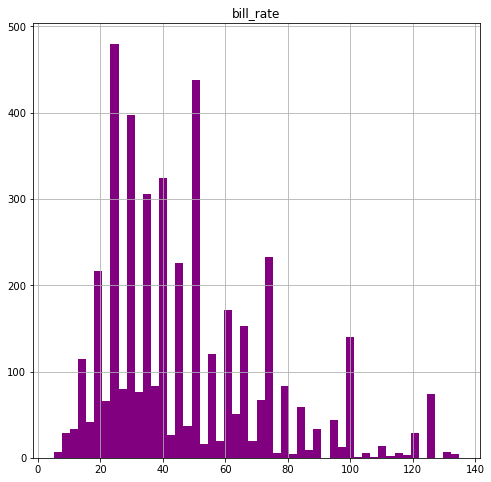

In [20]:
all_bill_rates = merged['bill_rate']

all_bill_range = np.ptp(all_bill_rates)
all_bill_min = np.amin(all_bill_rates)
all_bill_max = np.amax(all_bill_rates)

print ("Overall bill rate minimum: ${0}".format(all_bill_min))
print("Overall bill rate maximum: ${0}".format(all_bill_max))
print("Overall bill rate range: ${0}".format(all_bill_range))

merged.hist(column='bill_rate', figsize=(8,8), color="purple", bins=50)

Female bill rate minimum: $5.0
Female bill rate maximum: $135.0
Female bill rate range: $130.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdbc8703410>]], dtype=object)

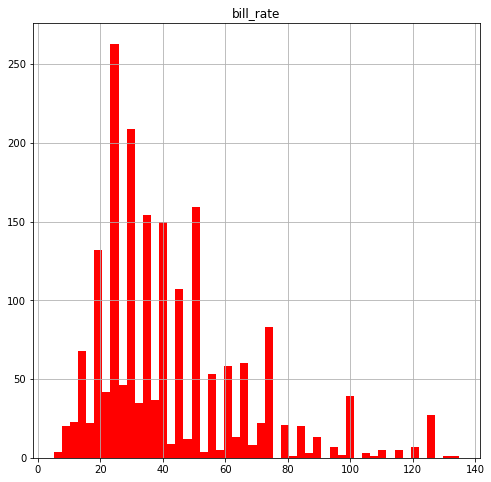

In [21]:
female_bill_rates = merged[merged['gender'] == 'female']['bill_rate']

female_bill_range = np.ptp(female_bill_rates)
female_bill_min = np.amin(female_bill_rates)
female_bill_max = np.amax(female_bill_rates)

female_df = merged[merged['gender'] == 'female']

print ("Female bill rate minimum: ${0}".format(female_bill_min))
print("Female bill rate maximum: ${0}".format(female_bill_max))
print("Female bill rate range: ${0}".format(female_bill_range))

female_df.hist(column='bill_rate', figsize=(8,8), color="red", bins=50)

Male bill rate minimum: $5.99
Male bill rate maximum: $135.0
Male bill rate range: $129.01


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdbc857b590>]], dtype=object)

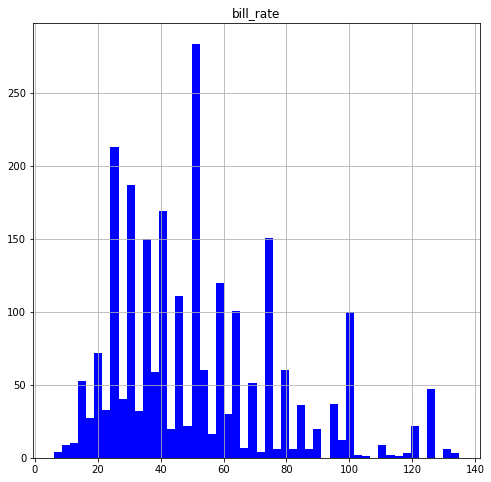

In [22]:
male_bill_rates = merged[merged['gender'] == 'male']['bill_rate']

male_bill_range = np.ptp(male_bill_rates)
male_bill_min = np.amin(male_bill_rates)
male_bill_max = np.amax(male_bill_rates)

male_df = merged[merged['gender'] == 'male']

print ("Male bill rate minimum: ${0}".format(male_bill_min))
print("Male bill rate maximum: ${0}".format(male_bill_max))
print("Male bill rate range: ${0}".format(male_bill_range))

male_df.hist(column='bill_rate', figsize=(8,8), color="blue", bins=50)

# Removing Outliers from Male and Female Sample

Noticing the large range of bill rates for male workers on Upwork, we removed outliers whose bill rate was more or less than two standard deviations of the average bill rate for male and female workers. In this revised sample, the average hourly bill rate for men was USD \$44.70 (std = USD \$49.82), and the range was USD \$122.00. For women, the average hourly bill rate was USD \$35.29 (std = USD \$26.09), and the range was USD \$82.00. 

Male bill rate average: 51.8620422535
Male bill rate standard deviation: 26.2678327042
Male bill rate minimum: $5.99
Male bill rate maximum: $104.0
Male bill rate range: $98.01


/home/ecf384/.conda/envs/eureka2/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/ecf384/.conda/envs/eureka2/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdbc83e78d0>]], dtype=object)

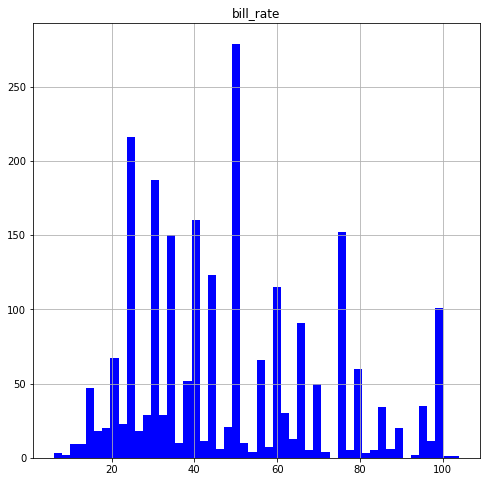

In [23]:
male_sd = np.std(merged[merged['gender'] == 'male']['bill_rate'])
male_mean = np.mean(merged[merged['gender'] == 'male']['bill_rate'])
print("Male bill rate average: {0}".format(male_mean))
print("Male bill rate standard deviation: {0}".format(male_sd))
male_no_outliers_df = merged[merged['gender'] == 'male']
male_no_outliers_df = male_no_outliers_df[merged['bill_rate'] > male_mean - 2 * male_sd]
male_no_outliers_df = male_no_outliers_df[merged['bill_rate'] < male_mean + 2 * male_sd]

male_bill_range = np.ptp(male_no_outliers_df['bill_rate'])
male_bill_min = np.amin(male_no_outliers_df['bill_rate'])
male_bill_max = np.amax(male_no_outliers_df['bill_rate'])

print ("Male bill rate minimum: ${0}".format(male_bill_min))
print("Male bill rate maximum: ${0}".format(male_bill_max))
print("Male bill rate range: ${0}".format(male_bill_range))

male_no_outliers_df.hist(column='bill_rate', figsize=(8,8), color="blue", bins=50)

Female bill rate average: 42.3207420676
Female bill rate standard deviation: 23.5979014908
Female bill rate minimum: $5.0
Female bill rate maximum: $89.0
Female bill rate range: $84.0


/home/ecf384/.conda/envs/eureka2/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/ecf384/.conda/envs/eureka2/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdbc82d5510>]], dtype=object)

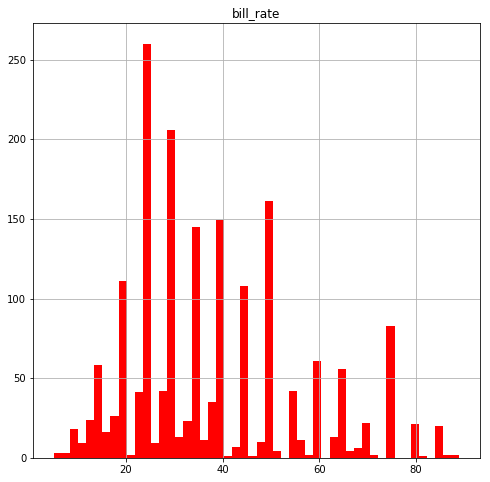

In [24]:
female_sd = np.std(merged[merged['gender'] == 'female']['bill_rate'])
female_mean = np.mean(merged[merged['gender'] == 'female']['bill_rate'])
print("Female bill rate average: {0}".format(female_mean))
print("Female bill rate standard deviation: {0}".format(female_sd))
female_no_outliers_df = merged[merged['gender'] == 'female']
female_no_outliers_df = female_no_outliers_df[merged['bill_rate'] > female_mean - 2 * female_sd]
female_no_outliers_df = female_no_outliers_df[merged['bill_rate'] < female_mean + 2 * female_sd]

female_bill_range = np.ptp(female_no_outliers_df['bill_rate'])
female_bill_min = np.amin(female_no_outliers_df['bill_rate'])
female_bill_max = np.amax(female_no_outliers_df['bill_rate'])

print ("Female bill rate minimum: ${0}".format(female_bill_min))
print("Female bill rate maximum: ${0}".format(female_bill_max))
print("Female bill rate range: ${0}".format(female_bill_range))

female_no_outliers_df.hist(column='bill_rate', figsize=(8,8), color="red", bins=50)

# Bill Rate Across Job Categories

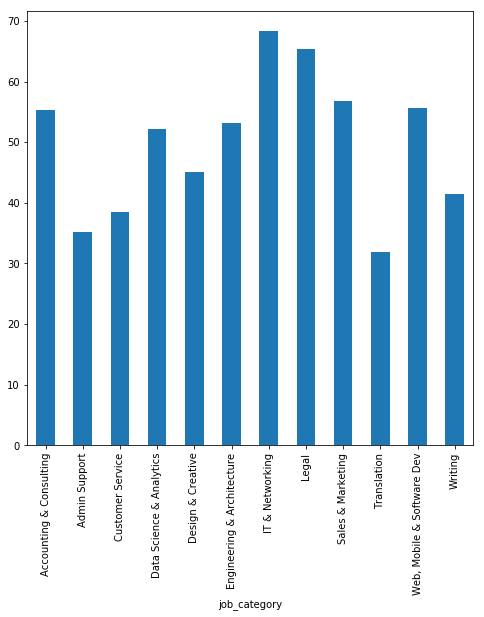

In [26]:
gender_table= merged.groupby('job_category')['bill_rate'].mean()
gender_table.plot(kind="bar", figsize=(8,8))

# Distribution of Covariates

Below we report on the distribution of the covariate values for the sample. 

# Highest Level of Education by Gender

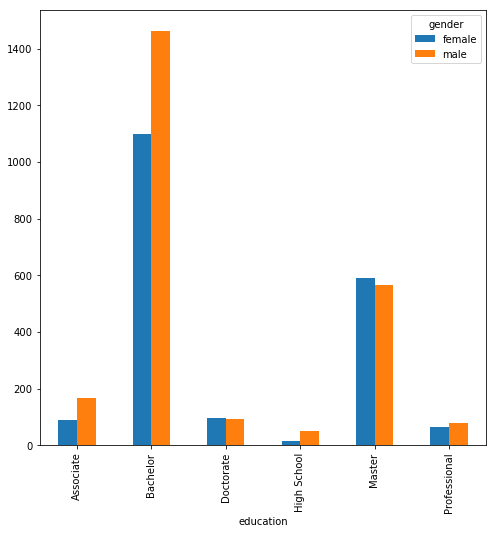

In [27]:
education_table = pd.crosstab(merged['education'], merged['gender'])
education_table.plot(kind="bar", figsize=(8,8))

# Primary Job Category by Gender

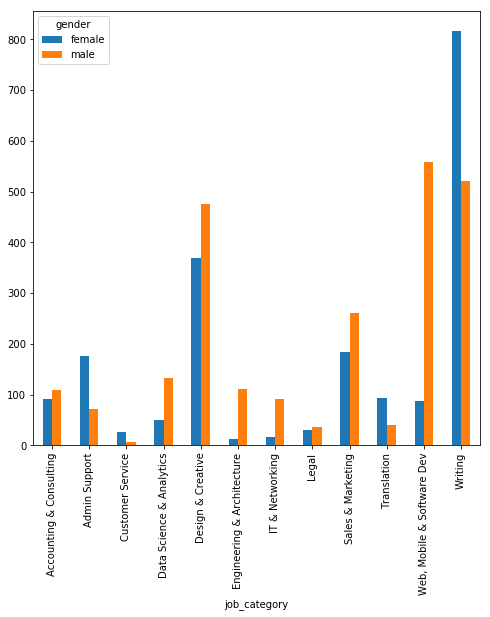

In [28]:
job_category_table = pd.crosstab(merged['job_category'], merged['gender'])
job_category_table.plot(kind="bar", figsize=(8,8))

# Distribution of Work Experience by Gender

Distribution of work experience (years) for men and women in the U.S. on Upwork

In [29]:
# Get work experience distribution 
merged.hist(column='work_experience', figsize=(8,8), color="purple", bins=50)

KeyError: "['work_experience'] not in index"

In [30]:
# Work experience distribution for women 
female_df = merged[merged['gender'] == 'female']
female_df.hist(column='work_experience', figsize=(8,8), color="red", bins=50)

KeyError: "['work_experience'] not in index"

In [31]:
# Work experience distribution for men 
male_df = merged[merged['gender'] == 'male']
male_df.hist(column='work_experience', figsize=(8,8), color="blue", bins=50)

KeyError: "['work_experience'] not in index"

# Additional Analyses for Evaluating Statistical Significance

# Comparing Average Bill Rate Across Genders

Average bill rate is significantly different between men and women in the U.S. on Upwork (p < 0.001). 

In [32]:
# Computing statistical significance of bill rate between men and women on Upwork
model = ols("bill_rate ~ gender", merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print anova_table

                            OLS Regression Results                            
Dep. Variable:              bill_rate   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     155.9
Date:                Tue, 05 Dec 2017   Prob (F-statistic):           3.59e-35
Time:                        12:38:29   Log-Likelihood:                -20277.
No. Observations:                4368   AIC:                         4.056e+04
Df Residuals:                    4366   BIC:                         4.057e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         42.3207      0.568     74.

# Comparing Average Bill Rate Across Job Categories

Average bill rate is significantly different between workers in different job categories in the U.S. on Upwork (p < 0.001). 

In [33]:
# Computing statistical significance of bill rate between people from different job categories on Upwork worldwide
model = ols("bill_rate ~ job_category", merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print anova_table

                            OLS Regression Results                            
Dep. Variable:              bill_rate   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     45.72
Date:                Tue, 05 Dec 2017   Prob (F-statistic):           3.42e-95
Time:                        12:38:46   Log-Likelihood:                -20115.
No. Observations:                4368   AIC:                         4.025e+04
Df Residuals:                    4356   BIC:                         4.033e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

# Comparing Average Bill Rate Across Highest Levels of Education

Average bill rate is significantly different between workers with different highest levels of education (p < 0.01).

In [34]:
# Computing statistical significance of bill rate between people with different education on Upwork worldwide
model = ols("bill_rate ~ education", merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print anova_table

                            OLS Regression Results                            
Dep. Variable:              bill_rate   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     8.706
Date:                Tue, 05 Dec 2017   Prob (F-statistic):           3.17e-08
Time:                        12:39:17   Log-Likelihood:                -20332.
No. Observations:                4368   AIC:                         4.068e+04
Df Residuals:                    4362   BIC:                         4.071e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

# Comparing Average Bill Rate Across All Covariates and Genders

Average bill rate is significantly different between workers, taking into account all covariate values and gender (p < 0.001). 

In [35]:
# Computing statistical significance using model with all covariates
model = ols("bill_rate ~ job_category_id + education + gender + work_experience", merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print anova_table

NameError: name 'work_experience' is not defined

# Average Bill Rate of Male and Female Web Developers

Comparing the bill rates of web developers in the United States (n = 178), we find no statistically significant difference between the average bill rate of men (M = USD \$39.92, sd = USD \$21.46) and women (M = USD \$39.81, sd = USD \$21.79). 

In [36]:
web_developers_df = merged[merged['job_category'] == 'Web, Mobile & Software Dev']
male_web_dev = web_developers_df[web_developers_df['gender'] == 'male']['bill_rate']
female_web_dev = web_developers_df[web_developers_df['gender'] == 'female']['bill_rate']

print "Male web dev average: {0}".format(np.mean(male_web_dev))
print np.std(male_web_dev)
print "Female web dev average: {0}".format(np.mean(female_web_dev))
print np.std(female_web_dev)

web_dev_model = ols("bill_rate ~ gender", web_developers_df).fit()
web_dev_anova_table = sm.stats.anova_lm(web_dev_model, typ=2)

print(web_dev_model.summary())
print web_dev_anova_table

Male web dev average: 56.3106261181
24.3917891358
Female web dev average: 50.88625
24.7202078871
                            OLS Regression Results                            
Dep. Variable:              bill_rate   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.735
Date:                Tue, 05 Dec 2017   Prob (F-statistic):             0.0537
Time:                        12:39:56   Log-Likelihood:                -2985.9
No. Observations:                 647   AIC:                             5976.
Df Residuals:                     645   BIC:                             5985.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

# Comparing Bill Rate Across Job Categories and Gender

Difference for Accounting & Consulting (men vs women): 16.4347277623
Difference for Admin Support (men vs women): 8.62315827166
Difference for Customer Service (men vs women): 6.72884615385
Difference for Data Science & Analytics (men vs women): 7.08172631579
Difference for Design & Creative (men vs women): -1.18397917558
Difference for Engineering & Architecture (men vs women): 20.5471621622
Difference for IT & Networking (men vs women): 4.38576086957
Difference for Legal (men vs women): 14.6547849462
Difference for Sales & Marketing (men vs women): 5.50327482092
Difference for Translation (men vs women): 6.09764227642
Difference for Web, Mobile & Software Dev (men vs women): 5.42437611807
Difference for Writing (men vs women): 5.59548227753


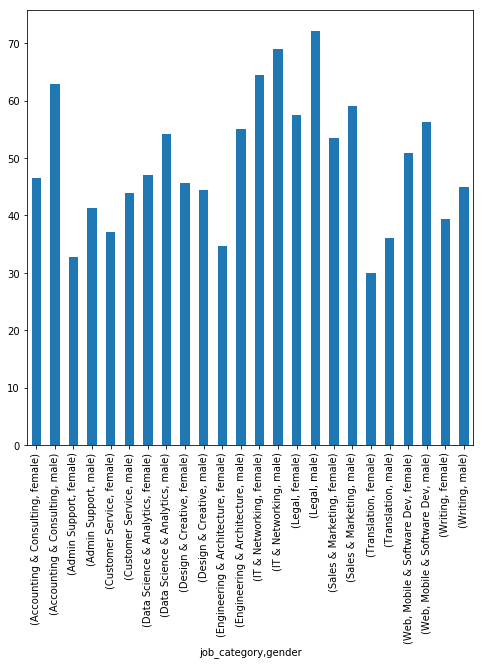

In [37]:
gender_table= merged.groupby(['job_category','gender'])['bill_rate'].mean()

#job_category_rate_table = pd.crosstab(gender_table)
gender_table.plot(kind="bar", figsize=(8,8))

i = 0
job_category_index = 0
bill_rate_difference = 0
job_categories = ["Accounting & Consulting", "Admin Support", 
                  "Customer Service", "Data Science & Analytics", "Design & Creative", 
                  "Engineering & Architecture", "IT & Networking", "Legal", "Sales & Marketing",
                  "Translation", "Web, Mobile & Software Dev", "Writing"]

bill_rate_diff = []


for entry in gender_table:
    if (i % 2 != 0):
        bill_rate_difference = gender_table[i] - gender_table[i-1]
        print("Difference for {0} (men vs women): {1}".format(job_categories[job_category_index], bill_rate_difference))
        bill_rate_diff.append(bill_rate_difference)
        job_category_index += 1
    i += 1

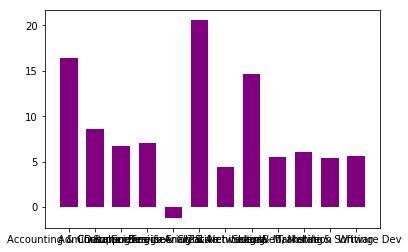

In [38]:
# Plot bar chart of the difference in bill rate by job category

y = bill_rate_diff
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
width = 1/1.5
bar_chart = plt.bar(x, y, width, color="purple", tick_label=job_categories)

# Things to Look Into Next

https://matplotlib.org/devdocs/gallery/shapes_and_collections/scatter.html#sphx-glr-gallery-shapes-and-collections-scatter-py

http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html
